In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import LTransform as LT
import numpy as np
import matplotlib.pyplot as plt
from utils import calculate_angles_between_vectors, calculate_lateral_deviation

In [4]:
model_num = 1
phase = 1


model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='try13')
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

Directory '/Users/mahdiyarshahbazi/Documents/Data/MotorNet/try13' already exists.


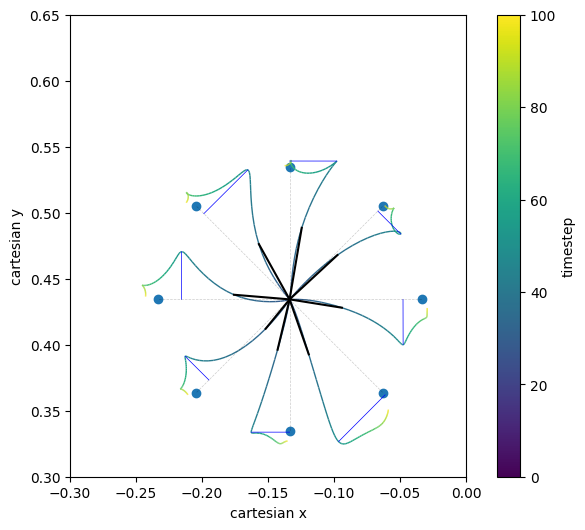

In [6]:
xy, tg, all_hidden, all_muscles, vel = test(cfg_file,weight_file,ff_coefficient=8)
fig, ax  = plot.plot_simulations(xy=xy,target_xy=tg, vel=vel,figsize=(8,6))

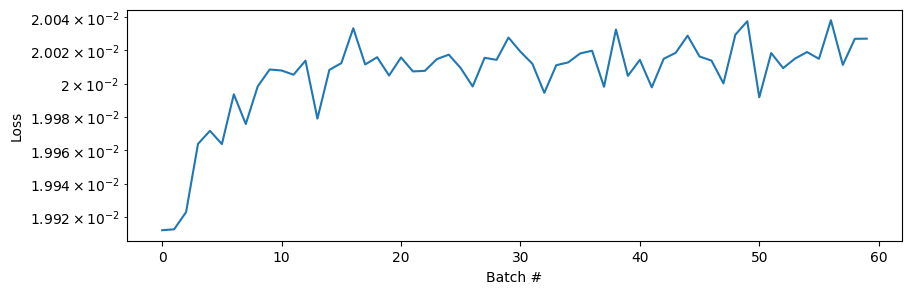

In [7]:
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log=log,loss_type='position_loss')

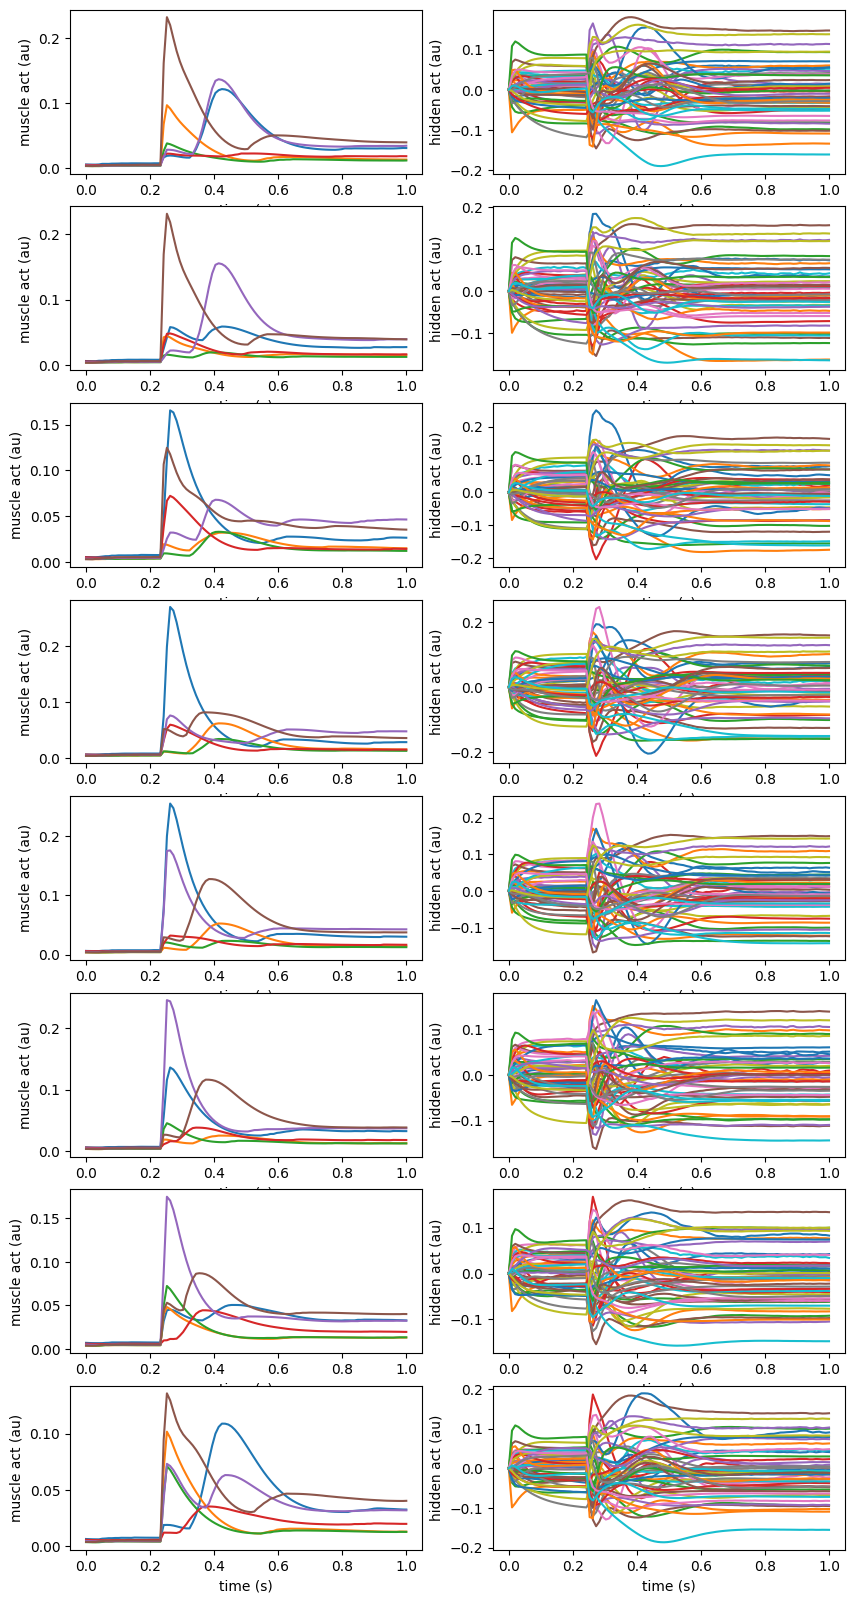

In [8]:
fig, ax = plot.plot_activation(all_hidden, all_muscles)
fig.savefig(os.path.join(data_dir,'activations.png'),dpi=300)